# Segmentation Evaluation In Python

Import Necessary Libraries

In [5]:
import SimpleITK as sitk

import numpy as np
import pydicom
import scipy
import scipy.misc
from medpy import metric
from surface import Surface
import mainPreProcessingSegmentationMasks as read_dcm

import matplotlib.pyplot as plt
%matplotlib inline

from ipywidgets import interact, fixed

Dimensions of tumor image: (48, 207, 15)
Spacing of tumor image: (0.80078125, 0.80078125, 1.0)
Origin of tumor image: (-12.244199752807617, -282.5610046386719, -123.0)
Direction of tumor image: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Pixel ID Value: 4


Dimensions of ablation image: (37, 46, 35)
Spacing of ablation image: (0.80078125, 0.80078125, 1.0)
Origin of ablation image: (-17.24799919128418, -289.76800537109375, -137.5)
Direction of ablation image: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Pixel ID Value: 4


Dimensions of plan image: (512, 512, 242)
Spacing of plan image: (0.80078125, 0.80078125, 1.0)
Origin of plan image: (-171.599609375, -425.099609375, -240.0)
Direction of plan image: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Pixel ID Value: 2


Dimensions of validation image: (512, 512, 194)
Spacing of validation image: (0.80078125, 0.80078125, 1.0)
Origin of validation image: (-172.599609375, -425.099609375, -189.5)
Direction of validation image: (1.0, 0.0, 0.

Utility Display for Segmentation Visualization

In [18]:
def display_with_overlay(slice_number, image, segs, window_min, window_max):
    
    """
    Display a CT slice with segmented contours overlaid onto it. The contours are the edges of 
    the labeled regions.
    """
    img = image[:,:,slice_number]
    msk = segs[:,:,slice_number]
    overlay_img = sitk.LabelMapContourOverlay(sitk.Cast(msk, sitk.sitkLabelUInt8), 
                                              sitk.Cast(sitk.IntensityWindowing(img,
                                                                                windowMinimum=window_min, 
                                                                                windowMaximum=window_max), 
                                                        sitk.sitkUInt8), 
                                             opacity = 1, 
                                             contourThickness=[2,2])
    #We assume the original slice is isotropic, otherwise the display would be distorted 
    plt.imshow(sitk.GetArrayViewFromImage(overlay_img))
    plt.axis('off')
    plt.show()

Display Image with SimpleITK

In [19]:
def sitk_show(img, title=None, margin=0.05, dpi=40 ):
    nda = sitk.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    
    if title:
        plt.title(title)
    
    plt.show()

Load the Images and Masks

In [20]:
#image = sitk.ReadImage("tumorSegm", sitk.sitkUInt8)
image = read_dcm.resizedTumorMask

#segmentation =  sitk.ReadImage("ablationSegm",sitk.sitkUInt8)
segmentation = read_dcm.resizedAblationMask


In [21]:
print(image.GetSize())
print(image.GetSpacing())
print(segmentation.GetSpacing())
print(image.GetDimension())
print(image.GetDirection())
print(image.GetPixelIDValue())
print(segmentation.GetPixelIDValue())
print(segmentation.GetSize())
print(segmentation.GetDimension())

(512, 512, 242)
(0.80078125, 0.80078125, 1.0)
(0.80078125, 0.80078125, 1.0)
3
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
2
2
(512, 512, 242)
3


Display the images

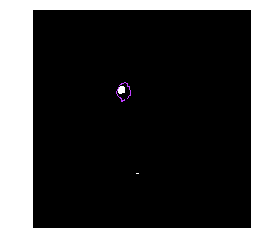

In [23]:
interact(display_with_overlay, 
         slice_number = (0, image.GetSize()[2]-1), image = fixed(image),
         segs = fixed(segmentation), window_min = fixed(0), window_max=fixed(1));

Evaluate with overlap metrics and surface distance metrics

In [7]:
from enum import Enum

# Use enumerations to represent the various evaluation measures
class OverlapMeasures(Enum):
    jaccard, dice, volume_similarity, false_negative, false_positive = range(5)

class SurfaceDistanceMeasures(Enum):
    hausdorff_distance, mean_surface_distance, median_surface_distance, std_surface_distance, max_surface_distance = range(5)

In [8]:
# Select which reference we want to use (majority vote or STAPLE)    
reference_segmentation = image #which is actually the tumor segmentation

# Empty numpy arrays to hold the results 
overlap_results = np.zeros((1,len(OverlapMeasures.__members__.items())))  
surface_distance_results = np.zeros((1,len(SurfaceDistanceMeasures.__members__.items())))  
print(surface_distance_results.shape)
print(overlap_results.shape)

(1, 5)
(1, 5)


# Compute the evaluation criteria


In [9]:
overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()

hausdorff_distance_filter = sitk.HausdorffDistanceImageFilter()

Compute Average symmetric surface distance (assd) and Maximum surface distance (Symmetric Hausdorff Distance) - msd

In [10]:
volscores = {}
ref = sitk.GetArrayFromImage(image)
seg = sitk.GetArrayFromImage(segmentation)
volscores['rvd'] = metric.ravd(seg, ref)
volscores['dice'] = metric.dc(seg,ref)
volscores['jaccard'] = metric.binary.jc(seg,ref)
volscores['voe'] = 1. - volscores['jaccard']

vxlspacing = np.asarray(segmentation.GetSpacing()) # assuming both segmentation and image have the same spacing
#[1.0,0.845703125,0.845703125]

if np.count_nonzero(seg) ==0 or np.count_nonzero(ref)==0:
		volscores['assd'] = 0
		volscores['msd'] = 0
else:
    
		evalsurf = Surface(seg,ref, physical_voxel_spacing = vxlspacing , mask_offset = [0.,0.,0.], reference_offset = [0.,0.,0.])
		volscores['assd'] = evalsurf.get_average_symmetric_surface_distance()
		volscores['msd'] = metric.hd(ref,seg,voxelspacing=vxlspacing)

Use the absolute values of the distance map to compute the surface distances (distance map sign, outside or inside 
 relationship, is irrelevant)

In [11]:
reference_distance_map = sitk.Abs(sitk.SignedMaurerDistanceMap(reference_segmentation, squaredDistance=False))
label_intensity_statistics_filter = sitk.LabelIntensityStatisticsImageFilter()
label = 255  # color white - foreground pixels

In [12]:
overlap_measures_filter.Execute(reference_segmentation, segmentation)
overlap_results[0,OverlapMeasures.jaccard.value] = overlap_measures_filter.GetJaccardCoefficient()
overlap_results[0,OverlapMeasures.dice.value] = overlap_measures_filter.GetDiceCoefficient()
overlap_results[0,OverlapMeasures.volume_similarity.value] = overlap_measures_filter.GetVolumeSimilarity()
overlap_results[0,OverlapMeasures.false_negative.value] = overlap_measures_filter.GetFalseNegativeError()
overlap_results[0,OverlapMeasures.false_positive.value] = overlap_measures_filter.GetFalsePositiveError()

In [13]:
# Hausdorff distance
hausdorff_distance_filter.Execute(reference_segmentation, segmentation)
surface_distance_results[0,SurfaceDistanceMeasures.hausdorff_distance.value] = hausdorff_distance_filter.GetHausdorffDistance()
# Surface distance measures
segmented_surface = sitk.LabelContour(segmentation)
label_intensity_statistics_filter.Execute(segmented_surface, reference_distance_map)
surface_distance_results[0,SurfaceDistanceMeasures.mean_surface_distance.value] = label_intensity_statistics_filter.GetMean(label)
surface_distance_results[0,SurfaceDistanceMeasures.median_surface_distance.value] = label_intensity_statistics_filter.GetMedian(label)
surface_distance_results[0,SurfaceDistanceMeasures.std_surface_distance.value] = label_intensity_statistics_filter.GetStandardDeviation(label)
surface_distance_results[0,SurfaceDistanceMeasures.max_surface_distance.value] = label_intensity_statistics_filter.GetMaximum(label)

Print the matrices for overlap metrics and surface distance

In [14]:
np.set_printoptions(precision=3)
print(overlap_results)
print(surface_distance_results)

[[ 0.172  0.294 -1.253  0.819  0.212]]
[[ 26.628  10.248   8.133   7.892  29.   ]]


,rvd,dice,jaccard,voe,assd,msd
0,3.357,0.294,0.172,0.828,6.405,27.023


,jaccard,dice,volume_similarity,false_negative,false_positive
0,0.172,0.294,-1.253,0.819,0.212


,hausdorff_distance,mean_surface_distance,median_surface_distance,std_surface_distance,max_surface_distance
0,26.628,10.248,8.133,7.892,29.000


,rvd,dice,jaccard,voe,assd,msd
0,3.357,0.294,0.172,0.828,6.405,27.023


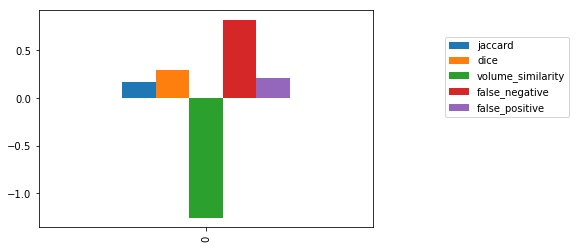

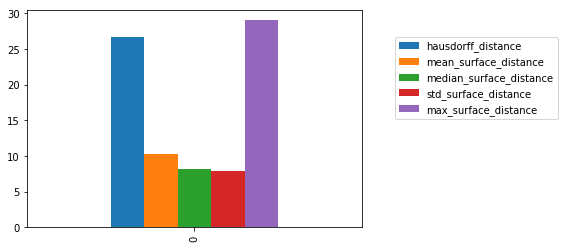

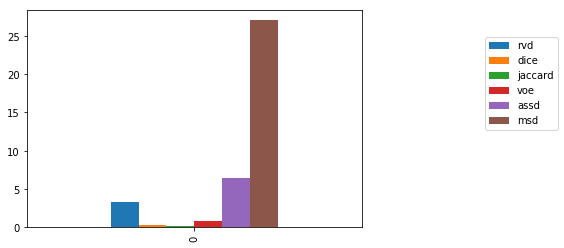

In [15]:
import pandas as pd
from IPython.display import display, HTML 

# Graft our results matrix into pandas data frames 
overlap_results_df = pd.DataFrame(data=overlap_results, index = list(range(1)), 
                                  columns=[name for name, _ in OverlapMeasures.__members__.items()]) 

surface_distance_results_df = pd.DataFrame(data=surface_distance_results, index = list(range(1)), 
                                  columns=[name for name, _ in SurfaceDistanceMeasures.__members__.items()]) 

seg_quality_results_df = pd.DataFrame(data=volscores, index = list(range(1)), 
                                  columns=[name for name, _ in volscores.items()]) 

display(HTML(seg_quality_results_df.to_html(float_format=lambda x: '%.3f' % x)))
# Display the data as HTML tables and graphs
display(HTML(overlap_results_df.to_html(float_format=lambda x: '%.3f' % x)))
display(HTML(surface_distance_results_df.to_html(float_format=lambda x: '%.3f' % x)))
display(HTML(seg_quality_results_df.to_html(float_format=lambda x: '%.3f' % x)))
overlap_results_df.plot(kind='bar').legend(bbox_to_anchor=(1.6,0.9))
surface_distance_results_df.plot(kind='bar').legend(bbox_to_anchor=(1.6,0.9))
seg_quality_results_df.plot(kind='bar').legend(bbox_to_anchor=(1.6,0.9))